Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.9710 - val_loss: 1.0711
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.9296 - val_loss: 1.0289
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8857 - val_loss: 0.9829
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.8462 - val_loss: 0.9359
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.8053 - val_loss: 0.8848
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.7498 - val_loss: 0.8282
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.6971 - val_loss: 0.7660
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.6421 - val_loss: 0.6982
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.5832 - val_loss: 0.6252
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.5021 - val_loss: 0.5482
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.4282 - val_loss: 0.4697
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3723 - val_loss: 0.

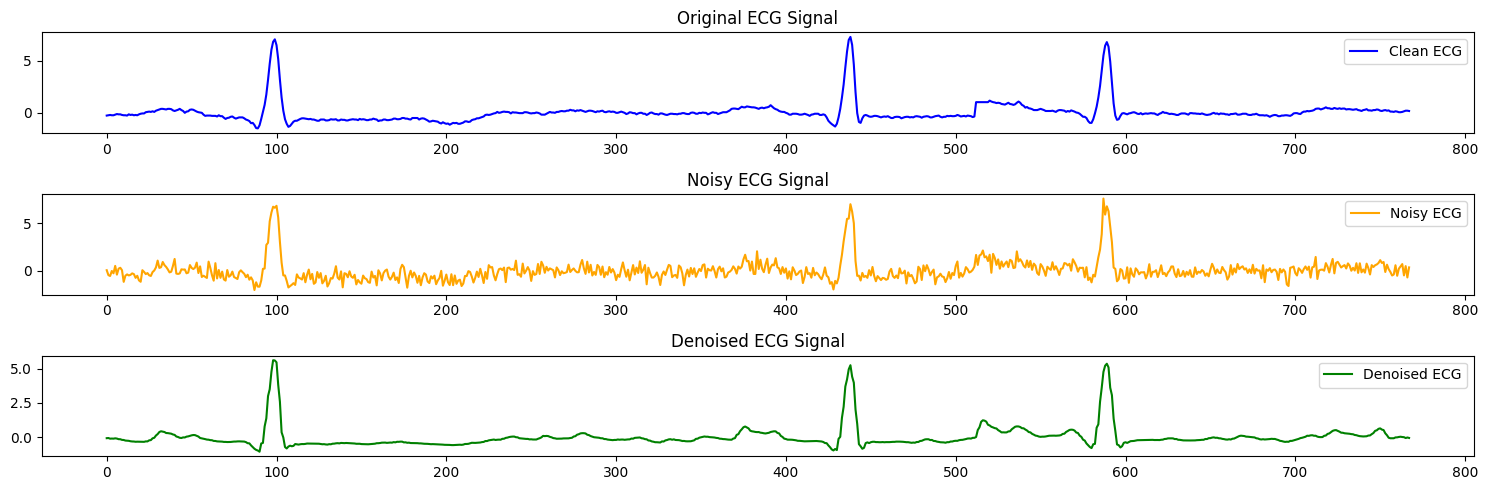

SNR (Noisy vs Clean): 6.44 dB
SNR (Denoised vs Clean): 10.84 dB


In [3]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import urllib.request
import os

# Step 1: Download and Prepare MIT-BIH Arrhythmia Database
def download_mit_bih():
    records = ['100', '101', '102', '103', '104']  # Subset of records for demo
    base_url = 'https://physionet.org/files/mitdb/1.0.0/'
    data_dir = 'mit_bih_data'
    os.makedirs(data_dir, exist_ok=True)

    for rec in records:
        for ext in ['.dat', '.hea', '.atr']:
            url = f"{base_url}{rec}{ext}"
            urllib.request.urlretrieve(url, f"{data_dir}/{rec}{ext}")
    return data_dir

# Step 2: Load and Preprocess ECG Data
def load_ecg_data(data_dir, record_name='100', sample_length=3600):
    record = wfdb.rdrecord(f"{data_dir}/{record_name}")
    signal = record.p_signal[:, 0]  # Use MLII lead
    signal = signal[:sample_length]  # Limit for demo
    scaler = StandardScaler()
    signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    return signal, scaler

# Step 3: Add Synthetic Noise (EMG, Baseline Wander, Powerline)
def add_noise(signal, noise_factor=0.5):
    emg_noise = np.random.normal(0, noise_factor, len(signal))
    baseline_wander = 0.05 * np.sin(np.linspace(0, 2 * np.pi, len(signal)))
    powerline_noise = 0.02 * np.sin(2 * np.pi * 60 * np.linspace(0, 1, len(signal)))
    noisy_signal = signal + emg_noise + baseline_wander + powerline_noise
    return noisy_signal

# Step 4: Prepare Dataset for Training
def prepare_dataset(signal, noisy_signal, window_size=256):
    X_clean, X_noisy = [], []
    for i in range(0, len(signal) - window_size, window_size):
        X_clean.append(signal[i:i + window_size])
        X_noisy.append(noisy_signal[i:i + window_size])
    X_clean = np.array(X_clean)[:, :, np.newaxis]
    X_noisy = np.array(X_noisy)[:, :, np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X_noisy, X_clean, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Step 5: Define CDAE-BAM Model
def build_cdae_bam(input_shape=(256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Add dropout to prevent overfitting
    encoded = layers.MaxPooling1D(2)(x)

    # Batch Attention Mechanism
    attention = layers.GlobalAveragePooling1D()(encoded)
    attention = layers.Dense(32, activation='relu')(attention)
    attention = layers.Dense(32, activation='sigmoid')(attention)
    attention = layers.Reshape((1, 32))(attention)
    x = layers.Multiply()([encoded, attention])

    # Decoder
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    decoded = layers.Conv1D(1, 3, padding='same', activation='linear')(x)

    model = models.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 6: Train and Evaluate Model
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=64):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size, verbose=1)
    return history

# Step 7: Visualize Results
def plot_results(signal, noisy_signal, denoised_signal, sample_length=1000):
    plt.figure(figsize=(15, 5))
    plt.subplot(3, 1, 1)
    plt.plot(signal[:sample_length], label='Clean ECG', color='blue')
    plt.title('Original ECG Signal')
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(noisy_signal[:sample_length], label='Noisy ECG', color='orange')
    plt.title('Noisy ECG Signal')
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(denoised_signal[:sample_length], label='Denoised ECG', color='green')
    plt.title('Denoised ECG Signal')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 8: Calculate SNR for Evaluation
def calculate_snr(clean_signal, noisy_signal, denoised_signal):
    noise = clean_signal - noisy_signal
    denoised_noise = clean_signal - denoised_signal
    snr_noisy = 10 * np.log10(np.var(clean_signal) / np.var(noise))
    snr_denoised = 10 * np.log10(np.var(clean_signal) / np.var(denoised_noise))
    return snr_noisy, snr_denoised

# Main Execution
if __name__ == "__main__":
    # Download data
    data_dir = download_mit_bih()

    # Load and preprocess ECG
    signal, scaler = load_ecg_data(data_dir)
    noisy_signal = add_noise(signal)

    # Prepare dataset
    X_train, X_test, y_train, y_test = prepare_dataset(signal, noisy_signal)

    # Build and train model
    model = build_cdae_bam()
    history = train_model(model, X_train, y_train, X_test, y_test)

    # Predict and inverse transform
    denoised_signal = model.predict(X_test)
    denoised_signal = denoised_signal.reshape(-1)
    test_signal = y_test.reshape(-1)
    test_noisy = X_test.reshape(-1)

    # Ensure signals are aligned for SNR calculation
    min_length = min(len(test_signal), len(test_noisy), len(denoised_signal))
    test_signal = test_signal[:min_length]
    test_noisy = test_noisy[:min_length]
    denoised_signal = denoised_signal[:min_length]

    # Visualize
    plot_results(test_signal, test_noisy, denoised_signal)

    # Evaluate SNR
    snr_noisy, snr_denoised = calculate_snr(test_signal, test_noisy, denoised_signal)
    print(f"SNR (Noisy vs Clean): {snr_noisy:.2f} dB")
    print(f"SNR (Denoised vs Clean): {snr_denoised:.2f} dB")